In [43]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"

# functions 
from sklearn.metrics import roc_auc_score
from skimage.measure import label

def clustertest(true,permutations,thresh):
    nperm = permutations.shape[-1]
    t_val = abs((true - np.mean(permutations,-1)) / np.std(permutations,-1)) # 2-sided
    above_threshold = t_val>thresh
    sig_clust = label(above_threshold)
    clust_sum = np.zeros(np.max(sig_clust))
    for c in range(1,max(sig_clust)+1):
        
        clust_sum[c-1] = np.sum(t_val[sig_clust==c])
    # get random clusters
    clust_sum_rand = np.zeros(nperm)
    for perm in range(nperm):
        compare_to = np.delete(permutations,perm,axis=-1)
        t_val = abs((permutations[:,perm] - np.mean(compare_to,-1)) / np.std(compare_to,-1))
        above_threshold = t_val>thresh
        sig_clust_rand = label(above_threshold)
        if np.max(sig_clust_rand)>0:
            clust_sum_r = np.zeros(np.max(sig_clust_rand))
            for c in range(1,max(sig_clust_rand)+1):
                clust_sum_r[c-1] = np.sum(t_val[sig_clust_rand==c])
            clust_sum_rand[perm] = np.max(clust_sum_r)
    # compard random and true
    P = np.zeros(true.shape)*np.nan
    for c in range(len(clust_sum)):
        P[sig_clust==c+1] = np.mean(clust_sum[c]<=clust_sum_rand)
    return P

def getAUROC(true,pred):
    ''' compute AUC of classifier for a temporal generalization matrix 
    pred is a matrix of shape ntrials x nbins x nbins'''
    if len(pred.shape)==3:
        # AUC time x time matrix
        nbins = pred.shape[1]
        AUC = np.zeros((nbins,nbins))
        for b in range(nbins):
            for b2 in range(nbins):
                AUC[b,b2] = roc_auc_score(true,pred[:,b,b2])
    elif len(pred.shape)==2:
        nbins = pred.shape[1]
        AUC = np.zeros(nbins)
        for b in range(nbins):
            if len(true.shape)>1:
                AUC[b] = roc_auc_score(true[:,b],pred[:,b])
            else:
                AUC[b] = roc_auc_score(true,pred[:,b])
    elif len(pred.shape)==1:
        AUC = roc_auc_score(true,pred)
    return AUC

def designMatrix(globdev,local,stimulus=None,include_stim=False):
    '''
    design matrix of nsamples x nvariables
    Variables are: Stimulus, Local deviance, Global deviance, Blocktype (xx or xY)'''
    
    ntr = len(local)
    loc = local.copy();
    glob = globdev.copy()
    if include_stim:
        stim = stimulus.copy()
        X = np.vstack((loc,glob,stim,np.ones(ntr))).astype(float).T
    else:
        X = np.vstack((loc,glob,np.ones(ntr))).astype(float).T
        
    return X

def designMatrix_first3(blocks,stimulus):
    '''
    design matrix of nsamples x nvariables
    Variables are: Stimulus, Local deviance, Global deviance, Blocktype (xx or xY)'''
    
    ntr = len(blocks)
    context = blocks.copy()
    stim = stimulus.copy()
    X = np.vstack((context,stim,np.ones(ntr))).astype(float).T
    return X

def projectMUA(Coef,Y,Sess,Testtrials,compute_matrix = False):
    '''
    Projection of binned population MUA onto coefficient vector from 
    multivariate linear regression with cross-validation
    Projection onto single coefficient vector
    '''
    ntr,nch,nbins = Y.shape
    nsess = len(np.unique(Sess))
    nvar = Coef.shape[1]   
    
    Proj = np.zeros((nsess,nvar,ntr,nbins))# pre-allocate
    # project individual trials
    # use hold-out data per fold
    K = Coef.shape[-1]
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        sessind = np.where(Sess==sess)[0] # trial indices from session
        Ysess = Y[sessind,:] # MUA from session
        
        proj = np.zeros((nvar,len(sessind),nbins))
        for k in range(K): 
            test_ind = Testtrials[sess][k]
            # projection onto coefficients from each bin
            coef = preprocessing.normalize(Coef[sess,:,:,k],norm='l2',axis=1)
            for b in range(nbins):
                
                # project all bins onto this axis 
                proj[:,test_ind,b] = coef@Ysess[test_ind,:,b].T
                        
                # get inter-session projection, only for one fold
                if k==0:
                    Proj[sess,:][:,Sess!=sess,b] = coef@Y[Sess!=sess,:,b].T
            
        Proj[sess,:][:,sessind,:] = proj
        
    return Proj

def projectMUA_cv(Coef,Y,Sess,Testtrials,compute_matrix = False):
    '''
    Projection of binned population MUA onto coefficient vector from 
    multivariate linear regression with cross-validation
    compute_matrix: 
    '''
    nbins_train = Coef.shape[-2]
    ntr,nch,nbins = Y.shape
    nsess = len(np.unique(Sess))
    nvar = Coef.shape[1]   
    if compute_matrix == True:
        Proj = np.zeros((nsess,nvar,ntr,nbins_train,nbins))# pre-allocate
    else:
        Proj = np.zeros((nsess,nvar,ntr,nbins_train))# pre-allocate
    # project individual trials
    # use hold-out data per fold
    K = Coef.shape[-1]
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        sessind = np.where(Sess==sess)[0] # trial indices from session
        Ysess = Y[sessind,:] # MUA from session
        
        if compute_matrix == True:
            proj = np.zeros((nvar,len(sessind),nbins_train,nbins))
        else:
            proj = np.zeros((nvar,len(sessind),nbins_train))
        for k in range(K): 
            test_ind = Testtrials[sess][k]
            # projection onto coefficients from each bin
            for b in range(nbins_train):
                coef = preprocessing.normalize(Coef[sess,:,:,b,k],norm='l2',axis=1)

                # project all bins onto these axes (temporal generalization matrix)
                if compute_matrix == True:
                    for btest in range(nbins):
                        proj[:,test_ind,b,btest] = coef@Ysess[test_ind,:,btest].T
                        
                        # get inter-session projection, only for one fold
                        if k==0:
                            Proj[sess,:][:,Sess!=sess,b,btest] = coef@Y[Sess!=sess,:,btest].T
                # project only same bin as training
                else:
                    proj[:,test_ind,b] = coef@Ysess[test_ind,:,b].T
                        
                    # get inter-session projection, only for one fold
                    if k==0:
                        Proj[sess,:][:,Sess!=sess,b] = coef@Y[Sess!=sess,:,b].T
            
        Proj[sess,:][:,sessind,:] = proj
        
    return Proj


    
def MultivarRegression(X,Y,Sess,K,seed):
    ''' Mutlivariate regression within session
    
    Inputs:
    X: design matrix, Ntrials x Nvariables. Variables assumed to be in order: Local, Global, Blocktype, Stimulus, Noise
    Y: Firing rate per channel and time, Ntrials x Nchannels x Nbins
    Sess: session id for each trial
    K: number of cv folds per session
    
    Outputs:
    Coef: Coefficient matrix, Nsess x Nvar x Nch x Nbins x K
    Proba: Projection of each trial and time point onto population vectors, Nvar x Ntrials x Nbins
    Testtrials: indices of test folds per session
    
    '''
    np.random.seed(seed)
    nvar = X.shape[1] 
   
    ntr,nch,nbins = Y.shape # time dimension only because stimulus could change
    nsess = len(np.unique(Sess))
        
    
    # pre-allocate
    Coef = np.zeros((nsess,nvar,nch,nbins,K)) #coefficient matrix
    #Proba = np.zeros((nsess,nvar,ntr,nbins,nbins))
    Testtrials = [] # for storing test trials
    
  
    # determine population axes within each session
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        sessind = np.where(Sess==sess)[0]
        randind = np.random.permutation(len(sessind))
        ntest = int(len(sessind)/K)
        Testtrials.append([])
        Xsess = X[sessind,:].copy()
        
        Xsess[Xsess==0] = -1
        Ysess = Y[sessind,:]
        for k in range(K): 
            train_ind = np.delete(randind,np.arange(ntest*k,ntest*(k+1)))
            if k==K-1:
                test_ind = randind[ntest*k:]
            else:
                test_ind = randind[ntest*k:ntest*(k+1)]
            
            # balance training data: equal number of combinations of local dev/stand and global dev/stand
            #if nvar==3:
            balanced_train_ind = balance_data(Xsess[train_ind,:],train_ind,False) # w/o stimulus
            #else:
                #balanced_train_ind = balance_data(Xsess[train_ind,:],train_ind,False) # w stimulus
            # Regression
            for b in range(nbins):
                for ch in range(nch):
                    Coef[sess,:,ch,b,k] = np.linalg.inv(Xsess[balanced_train_ind,:].T@Xsess[balanced_train_ind,:])@Xsess[balanced_train_ind,:].T@Ysess[balanced_train_ind,ch,b]

            Testtrials[sess].append(test_ind) # store test indices
            
        
    return Coef,Testtrials


def balance_data(Xtrain, train_ind,include_stim):
    '''balance classes in data'''
    N = []
    if include_stim:
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                for l,v3 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                    n = sum((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2) & (Xtrain[:,3]==v3))
                    N.append(n)
        nmin = np.min(N)
        # subsample
        keep_ind = []
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                for l,v3 in enumerate(np.unique(Xtrain)):
                    # count trials of condition
                    condind = np.where((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2) & (Xtrain[:,3]==v3))[0] #balance local, global, stimulus
                    keep_ind.extend(condind[np.random.permutation(len(condind))[:nmin]])
    else:
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                n = sum((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2))
                N.append(n)
        nmin = np.min(N)
        # subsample
        keep_ind = []
        for i,v1 in enumerate(np.unique(Xtrain)):
            for j,v2 in enumerate(np.unique(Xtrain)):
                # count trials of condition
                condind = np.where((Xtrain[:,0]==v1) & (Xtrain[:,1]==v2))[0] #balance local, global, stimulus
                keep_ind.extend(condind[np.random.permutation(len(condind))[:nmin]])
    train_ind = train_ind[keep_ind]
    return train_ind

from sklearn.linear_model import LogisticRegression

def ItemNumberRegression(MUA,Session,Local,soa,binsize,shift,seq_start_bin,num_bins,nitems,K,seed=1):
    '''
    Perform multinomial logistic regression for item number decoding
    train only on xxxx trials (indicated in variable "Local"==0). Use K-fold cv
    
    MUA: has to start at time 0
    '''
    ntr,nch,nbins = MUA.shape
    nsess = len(np.unique(Session))
    Coef = np.ones((nsess,nitems,nch,K))*np.nan
    Proba = np.zeros((ntr,nbins,nitems))
    
    # get local standard trials
    xx_trials = (Local==0).astype(int)
    
    # choose bins used for training: stimulus duration=soa/2
    indices = []
    for i in range(nitems):
        indices.append(np.arange(seq_start_bin+int((i*soa+shift)/binsize),seq_start_bin+int((i*soa+shift)/binsize)+num_bins))
    print(indices)
    
    # create data matrix, averaging activity of each item in defined time bins
    M = np.zeros((ntr,nch,nitems)) #M = np.zeros((ntr,nch,4*num_bins))
    for i,ind in enumerate(indices):
        M[:,:,i] = np.mean(MUA[:,:,ind],-1) # average selected item bins
    
    # get number matrix as ground truth:
    y = np.arange(nitems)#[]
    
    # regression per session
    for sess in range(nsess):
        print('Session %s'%(sess+1))
        
        sessind = np.where(Session==sess)[0]
        randind = np.random.permutation(len(sessind))
        ntest = int(len(sessind)/K)
        Msess = M[sessind,:,:]
        MUAsess = MUA[sessind,:]
        proba = np.zeros((len(sessind),nbins,nitems))
        for k in range(K):

            # choose training and test data for fold k
            train_ind = np.delete(randind,np.arange(ntest*k,ntest*(k+1)))# subindices for training
            if k==K-1:
                test_ind = randind[ntest*k:]
            else:
                test_ind = randind[ntest*k:ntest*(k+1)]
                
            xx_train_ind = train_ind[xx_trials[sessind][train_ind]==1] #of these training trials, use only xxxx trials for training!
            ntrain = len(xx_train_ind)
        
            # reshape firing data matrix into bins*trials x nch
            X = np.reshape(np.swapaxes(Msess,0,1)[:,xx_train_ind,:],(nch,ntrain*len(y))).T
            Y = np.tile(y,ntrain)
            
            # TRAIN
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=1000).fit(X,Y)
            Coef[sess,:,:,k] = model.coef_
    
            # PREDICT probability for each item and time bin, test data
            for b in range(nbins):
                proba[test_ind,b,:] = model.predict_proba(MUAsess[test_ind,:,b])
        Proba[sessind,:] = proba    
           
    return Coef,Proba

Load preprocessed data and extract sequence variables

In [28]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe.pkl'%(animal_id)))

# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    
Session = np.concatenate([np.ones(len(Local[i]))*i for i in range(len(Local))])
Local = np.concatenate(Local)
Global = np.concatenate(Global)
Blocktype = np.concatenate(Blocktype)
Block = np.concatenate(Block)
Include = np.concatenate(Include)
StimID = np.concatenate(StimID)

['PFC_MU', 'PPC_MU', 'PFC_SU', 'PPC_SU', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']
Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


load PSTH and compute multivariate regression, last stimulus

In [51]:
include_stim = True

# what time period of sequence is considered:
which_period = 'last' # can be 'seq' or 'last' (only after last stim onset)


# load PSTH
MUA = []
sess = 0
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_last_gauss_%s.npy'%date))
        time_bins = np.load(os.path.join(out_path,'time_bins_gauss_%s.npy'%date))
        ntr,nch,nbins = Rb.shape
        # centre each channel
        Rc = Rb.copy()
        for ch in range(nch):
            Rc[:,ch,:] = (Rb[:,ch,:] - np.mean(Rb[:,ch,:])) / (np.std(Rb[:,ch,:]) + 10e-6) # centre each channel
        MUA.append(Rc)
        
        sess += 1
        
del Rb, Rc

MUA = np.concatenate(MUA)
nbins = len(time_bins)

# design matrix
X = designMatrix(Global[Include==1],Local[Include==1],StimID[Include==1],include_stim)
K = 10

# perform regression
Coef,Testfolds = MultivarRegression(X,MUA[Include==1,:],Session[Include==1],K,seed=43)
np.save(os.path.join(out_path,'Coef_%s_%s_%s.npy'%(which_period,exp,soa)),Coef)
# store information about test folds for each date
for i,d in enumerate(dates):
    Folds_dict = {}
    for j in range(K):
        Folds_dict[j] = list(Testfolds[i][j])
    np.save(os.path.join(out_path,'Testfolds_%s_%s_%s_%s.npy'%(d,which_period,exp,soa)),Folds_dict)

# Projections
gen_mat = True # if True, compute temporal generalization matrix
Proj = projectMUA_cv(Coef,MUA[Include==1,:],Session[Include==1],Testfolds,gen_mat)
np.save(os.path.join(out_path,'Proj_%s_%s_%s_%s.npy'%(which_period,gen_mat,exp,soa)),Proj)



Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312
Session 1
Session 2
Session 3
Session 4
Session 5
Session 6
Session 1
Session 2
Session 3
Session 4
Session 5
Session 6


multivariate regression whole sequence

In [32]:
which_period = 'first3' # can be 'first3', seq' or 'last' (only after last stim onset)

# load PSTH
MUA = []
sess = 0
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_%s.npy'%date))
        time_bins = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%date))
        ntr,nch,nbins = Rb.shape
        # centre each channel
        Rc = Rb.copy()
        for ch in range(nch):
            Rc[:,ch,:] = (Rb[:,ch,:] - np.mean(Rb[:,ch,:])) / (np.std(Rb[:,ch,:]) + 10e-6) # centre each channel
        MUA.append(Rc)
        
        sess += 1
        
del Rb, Rc

MUA = np.concatenate(MUA)
 # average over first three stim:
binsize = np.round(np.mean(np.diff(time_bins)),3)
b_start = int(np.round(abs(time_bins[0])/binsize))
b_end = int(np.round((abs(time_bins[0]) + 3*soa/1000)/binsize))
MUA_av = np.mean(MUA[:,:,b_start:b_end],-1)


xY_trials = np.where(Local==1)[0]
StimID_first3 = StimID.copy() # contains ID of last item
# change stim id on xY trials, from 0 to 1 or from 1 to 0
StimID_first3[xY_trials] = abs(StimID_first3[xY_trials] - 1)

# design matrix for first three items:
X = designMatrix_first3(Blocktype[Include==1],StimID_first3[Include==1])

K = 10
Coef,Testfolds = MultivarRegression(X,MUA_av[Include==1,:][:,:,np.newaxis],Session[Include==1],K,seed=43)
Coef = Coef[:,:,:,0,:]
np.save(os.path.join(out_path,'Coef_%s_%s_%s.npy'%(which_period,exp,soa)),Coef)
np.save(os.path.join(out_path,'Testfolds_%s_%s_%s.npy'%(which_period,exp,soa)),Testfolds)

# Projections
Proj = projectMUA(Coef,MUA[Include==1,:],Session[Include==1],Testfolds)
np.save(os.path.join(out_path,'Proj_%s_%s_%s.npy'%(which_period,exp,soa)),Proj)

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312
Session 1
Session 2
Session 3
Session 4
Session 5
Session 6


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Session 1
Session 2
Session 3
Session 4
Session 5
Session 6


Item number decoding

In [44]:
soa = .6
shift = binsize*4 # by how much to shift to take into account stimulus response (ms)
num_bins = int(.6/binsize ) # how large averaging window is for each item 
K = 10 # 10-fold cv
print('Shifting by %s ms the label of each item'%(shift*1000))
print('Averaging window for each item (ms): %s'%(num_bins*binsize*1000))
seq_start_bin = int(np.round(abs(time_bins[0])/binsize))
Coef,Proba = ItemNumberRegression(MUA,Session,Local,soa,binsize,shift,seq_start_bin,num_bins,4,K,seed=1)
np.save(os.path.join(out_path,'ItemNumber_Proba'),Proba)
np.save(os.path.join(out_path,'ItemNumber_Coef'),Coef)

Shifting by 100.0 ms the label of each item
Averaging window for each item (ms): 575.0000000000001
[array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31]), array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54]), array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79]), array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102])]
Session 1
Session 2
Session 3
Session 4
Session 5
Session 6


## Results
AUC: stimulus + context

In [33]:
nperm = 100
nsess = len(np.unique(Session))

# FIRST 3 STIMULI
Proj_first3 = np.load(os.path.join(out_path,'Proj_first3_%s_%s.npy'%(exp,soa)))
nbins = Proj_first3.shape[-1]
block_ax,stim_ax = 0,1

# design matrix with ground truth for stim id:
xY_trials = np.where(Local==1)[0]
StimID_first3 = StimID.copy() # contains ID of last item
# change stim id on xY trials, from 0 to 1 or from 1 to 0
StimID_first3[xY_trials] = abs(StimID_first3[xY_trials] - 1)

# now determine based on time vector when the last item starts
n_before_last = 3
binsize = np.round(np.mean(np.diff(time_bins)),3)
bins_until_last = int(np.round((abs(time_bins[0])+n_before_last*soa/1000)/binsize))
bins_after_last = nbins - bins_until_last

# design matrix for first three items:
include_stim = True
X = np.repeat(designMatrix(Global[Include==1],Local[Include==1],StimID_first3[Include==1],include_stim)[:,:,np.newaxis],bins_until_last,axis=-1) # repeat along time axis
X2 = np.repeat(designMatrix(Global[Include==1],Local[Include==1],StimID[Include==1],include_stim)[:,:,np.newaxis],bins_after_last,axis=-1) # repeat along time axis
X = np.concatenate((X,X2),axis=-1)
    
# STIMULUS
AUC_stim = np.zeros((nsess,nsess,3,nbins))
RandAUC_stim = np.zeros((nsess,nsess,3,nbins,nperm))
for sess in range(nsess):
    print('Stimulus, session %s'%(sess+1))
    for sess2 in range(nsess):
        for v in range(3): # overall or per condition
            if v==0:
                ind = (Session[Include==1]==sess2) & (Global[Include==1]==0)
            else: # local standards or deviants
                ind = (Session[Include==1]==sess2) & (Local[Include==1]==v-1) & (Global[Include==1]==0)
            Ysess = X[ind,-2,:] # stimulus variable
            for b in range(nbins):
                AUC_stim[sess,sess2,v,b] = getAUROC(Ysess[:,b].astype(float),Proj_first3[sess,stim_ax,ind,b][:,np.newaxis])[0]
            for perm in range(nperm): # permutations for diagonal of temp gen matrix only
                randind = np.random.permutation(sum(ind))
                for b in range(nbins):
                    RandAUC_stim[sess,sess2,v,b,perm] = getAUROC(Ysess[:,b].astype(float),Proj_first3[sess,stim_ax,ind,b][randind,np.newaxis])[0]
# BLOCKTYPE
AUC_block = np.zeros((nsess,nsess,nbins))
RandAUC_block = np.zeros((nsess,nsess,nbins,nperm))
for sess in range(nsess):
    print('Blocktype, session %s'%(sess+1))
    for sess2 in range(nsess):
        ind = (Session[Include==1]==sess2) & (Global[Include==1]==0)
        AUC_block[sess,sess2,:] = getAUROC(Blocktype[Include==1][ind].astype(float),Proj_first3[sess,block_ax,ind,:])
        for perm in range(nperm): # permutations for diagonal of temp gen matrix only
            randind = np.random.permutation(sum(ind))
            RandAUC_block[sess,sess2,:,perm] = getAUROC(Blocktype[Include==1][ind].astype(float),Proj_first3[sess,block_ax,ind,:][randind,:])
             
np.save(os.path.join(out_path,'AUC_Stim_first3_%s_%s.npy'%(exp,soa)),AUC_stim)
np.save(os.path.join(out_path,'AUC_Block_first3_%s_%s.npy'%(exp,soa)),AUC_block)
np.save(os.path.join(out_path,'AUCRand_Stim_first3_%s_%s.npy'%(exp,soa)),RandAUC_stim)
np.save(os.path.join(out_path,'AUCRand_Block_first3_%s_%s.npy'%(exp,soa)),RandAUC_block)

Stimulus, session 1
Stimulus, session 2
Stimulus, session 3
Stimulus, session 4
Stimulus, session 5
Stimulus, session 6
Blocktype, session 1
Blocktype, session 2
Blocktype, session 3
Blocktype, session 4
Blocktype, session 5
Blocktype, session 6


In [52]:
# time vectors
time_bins = np.load(os.path.join(out_path,'time_bins_gauss_%s.npy'%dates[0])) # time vector
time_bins_seq = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector
binsize = np.round(np.mean(np.diff(time_bins)),3)
time_bins = time_bins + binsize
time_bins_seq = time_bins_seq + binsize 

0.0
0.0


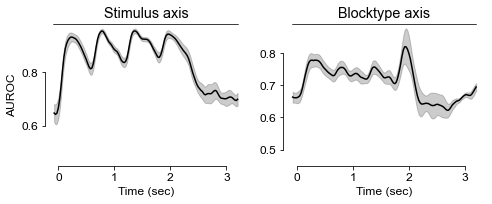

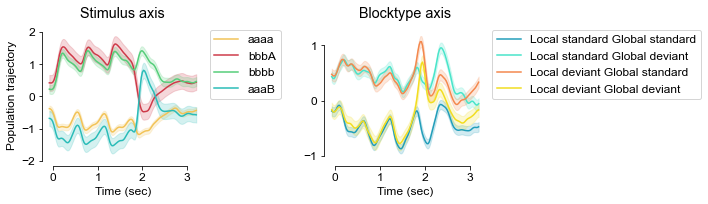

In [50]:
# plot
threshold = 4
alpha = .05
Axes = ['Stimulus','Blocktype']
nbins = len(time_bins_seq)
AUC = [AUC_stim[:,:,1,:],AUC_block]
RandAUC = [RandAUC_stim[:,:,1,:],RandAUC_block]

fig,ax = plt.subplots(1,len(Axes),figsize=(len(Axes)*3.5,3))
for v in range(len(Axes)):
    
    av = np.mean(np.diagonal(AUC[v],axis1=0,axis2=1),-1)
    randav = np.mean(np.diagonal(RandAUC[v],axis1=0,axis2=1),-1)
    sem = np.std(np.diagonal(AUC[v],axis1=0,axis2=1),-1)/np.sqrt(nsess)
    ax[v].fill_between(time_bins_seq,av-sem,av+sem,alpha=.2,color='k')
    ax[v].plot(time_bins_seq,av,color='k')
    
    # stats:
    ax[v].set_ylim(0.45,None)
    ymin,ymax = ax[v].get_ylim()
    p = clustertest(av,randav,threshold)
    l = label(~np.isnan(p))
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            print(p[l==j][0])
            ax[v].plot(time_bins_seq[l==j],np.ones(sum(l==j))*ymax,color='k',linewidth=1.5)
            
    for i in range(4):
        ax[v].fill_between(np.linspace(-i*soa/1000,-i*soa/1000+soa/1000/2,2),
                            np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
            
    ax[v].set_title('%s axis'%Axes[v])
    ax[v].set_xlabel('Time (sec)')
    
ax[0].set_ylabel('AUROC')

plt.tight_layout()
sb.despine(trim=True)
#plt.savefig(os.path.join(out_path,'plots','AUC_Stim+Block_%s_%s.pdf'%(exp,soa)))
plt.show()

# plot probability for trial types
block_ax,stim_ax = 0,1
nsess = Proj.shape[0]
fig,ax = plt.subplots(1,len(Axes),figsize=(len(Axes)*5,3))
Labels = ['standard','deviant']
StimLabels = [['aaaa','bbbA'],['bbbb','aaaB']]
Axes = ['Stimulus','Blocktype']
colors = [['#229eba','#48e5ca'], # local standards
         ['#f4884d','#f2dd20']] # local deviants

stim_colors = [['#f2c357','#ce3a49'], # A's
              ['#55ce7a','#2abcb8']] # B's
for v in range(len(Axes)):
    # structure variables:
    if Axes[v]!='Stimulus':
        for c in range(2):
            for c2 in range(2):
                av = np.zeros((nsess,nbins))
                for sess in range(nsess):
                    ind = (Local[(Include==1)]==c) & (Global[(Include==1)]==c2) & (Session[Include==1]==sess)
                    av[sess,:] = np.mean(Proj_first3[sess,block_ax,ind,:],0)
                av = np.mean(av,0)
                sem = np.std(av,0)/np.sqrt(nsess)
                ax[v].fill_between(time_bins_seq,av-sem,av+sem,alpha=.2,color=colors[c][c2])
                ax[v].plot(time_bins_seq,av,label='Local %s Global %s'%(Labels[c],Labels[c2]),color=colors[c][c2])
    else:
        for c in range(2):
            for c2 in range(2):
                av = np.zeros((nsess,nbins))
                for sess in range(nsess):
                    ind = (Local[(Include==1)]==c2) & (StimID[(Include==1)]==c) & (Session[Include==1]==sess)
                    av[sess,:] = np.mean(Proj_first3[sess,stim_ax,ind,:],0)
                av = np.mean(av,0)
                sem = np.std(av,0)/np.sqrt(nsess)
                ax[v].fill_between(time_bins_seq,av-sem,av+sem,alpha=.2,color=stim_colors[c][c2])
                ax[v].plot(time_bins_seq,av,label=StimLabels[c][c2],color=stim_colors[c][c2])
    ymin,ymax = ax[v].get_ylim()
    for i in range(4):
        ax[v].fill_between(np.linspace(-i*soa/1000,-i*soa/1000+soa/1000/2,2),
                            np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
    ax[v].set_title('%s axis'%Axes[v])
    ax[v].set_xlabel('Time (sec)')
    ax[v].legend(bbox_to_anchor=(1,1))

ax[0].set_ylabel('Population trajectory')
plt.tight_layout()
sb.despine(trim=True)
#plt.savefig(os.path.join(out_path,'plots','Projections_Stim+Block_first3_%s_%s.pdf'%(exp,soa)))
plt.show()

AUC: local + global

In [53]:
nperm = 100
nsess = len(np.unique(Session))
            
# LAST STIMULUS
gen_mat = True
Proj = np.load(os.path.join(out_path,'Proj_last_%s_%s_%s.npy'%(gen_mat,exp,soa)))
nbins = Proj.shape[-1]
loc_ax,glob_ax,stim_ax = 0,1,2

# GLOBAL
if gen_mat == True:
    AUC_glob = np.zeros((nsess,nsess,3,nbins,nbins))
else:
    AUC_glob = np.zeros((nsess,nsess,3,nbins))
RandAUC_glob = np.zeros((nsess,nsess,3,nbins,nperm))
for sess in range(nsess):
    print('Global, session %s'%(sess+1))
    for sess2 in range(nsess):
        for v in range(3): # overall or per condition
            if v==0:
                ind = Session[Include==1]==sess2
            else: # local standards or deviants
                ind = (Session[Include==1]==sess2) & (Local[Include==1]==v-1)
            if gen_mat == True:
                for b_test in range(nbins):
                    AUC_glob[sess,sess2,v,:,b_test] = getAUROC(Global[Include==1][ind].astype(float),Proj[sess,glob_ax,ind,:,b_test])
            else:
                AUC_glob[sess,sess2,v,:] = getAUROC(Global[Include==1][ind].astype(float),Proj[sess,glob_ax,ind,:])
            for perm in range(nperm): # permutations for diagonal of temp gen matrix only
                randind = np.random.permutation(sum(ind))
                if gen_mat == True:
                    for b in range(nbins):
                        RandAUC_glob[sess,sess2,v,b,perm] = getAUROC(Global[Include==1][ind].astype(float),Proj[sess,glob_ax,ind,b,b][randind,np.newaxis])[0]
                else:
                    RandAUC_glob[sess,sess2,v,:,perm] = getAUROC(Global[Include==1][ind].astype(float),Proj[sess,glob_ax,ind,:][randind,:])
                        
                        
# LOCAL
if gen_mat == True:
    AUC_loc = np.zeros((nsess,nsess,3,nbins,nbins))
else:
    AUC_loc = np.zeros((nsess,nsess,3,nbins))
RandAUC_loc = np.zeros((nsess,nsess,3,nbins,nperm))
for sess in range(nsess):
    print('Local, session %s'%(sess+1))
    for sess2 in range(nsess):
        for v in range(3): # overall or per condition
            if v==0:
                ind = Session[Include==1]==sess2
            else: # local standards or deviants
                ind = (Session[Include==1]==sess2) & (Blocktype[Include==1]==abs(v-2))
            if gen_mat == True:
                for b_test in range(nbins):
                    AUC_loc[sess,sess2,v,:,b_test] = getAUROC(Local[Include==1][ind].astype(float),Proj[sess,loc_ax,ind,:,b_test])
            else:
                AUC_loc[sess,sess2,v,:] = getAUROC(Local[Include==1][ind].astype(float),Proj[sess,loc_ax,ind,:])
            for perm in range(nperm): # permutations for diagonal of temp gen matrix only
                randind = np.random.permutation(sum(ind))
                if gen_mat == True:
                    for b in range(nbins):
                        RandAUC_loc[sess,sess2,v,b,perm] = getAUROC(Local[Include==1][ind].astype(float),Proj[sess,loc_ax,ind,b,b][randind,np.newaxis])[0]
                else:
                    RandAUC_loc[sess,sess2,v,:,perm] = getAUROC(Local[Include==1][ind].astype(float),Proj[sess,loc_ax,ind,:][randind,:])
                    

np.save(os.path.join(out_path,'AUC_Local_last_%s_%s_%s.npy'%(gen_mat,exp,soa)),AUC_loc)
np.save(os.path.join(out_path,'AUC_Global_last_%s_%s_%s.npy'%(gen_mat,exp,soa)),AUC_glob)
np.save(os.path.join(out_path,'AUCRand_Local_last_%s_%s.npy'%(exp,soa)),RandAUC_loc)
np.save(os.path.join(out_path,'AUCRand_Global_last_%s_%s.npy'%(exp,soa)),RandAUC_glob)

Global, session 1
Global, session 2
Global, session 3
Global, session 4
Global, session 5
Global, session 6
Local, session 1
Local, session 2
Local, session 3
Local, session 4
Local, session 5
Local, session 6


(60, 100)
0.0
(60, 100)
0.0


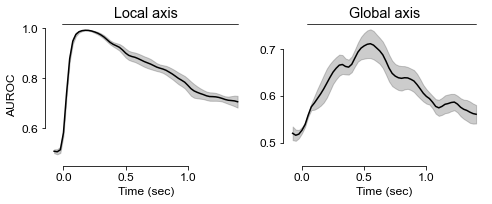

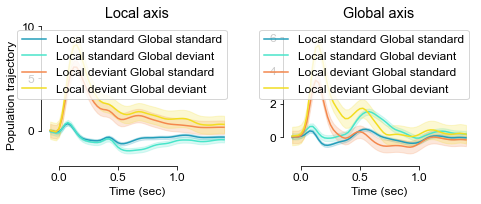

In [54]:
# plot
threshold = 4
alpha = .05

nsess = AUC_loc.shape[0]
nbins = len(time_bins)

Axes = ['Local','Global']
AUC = [np.diagonal(AUC_loc[:,:,0,:],axis1=2,axis2=3),np.diagonal(AUC_glob[:,:,0,:],axis1=2,axis2=3)]
RandAUC = [RandAUC_loc[:,:,0,:],RandAUC_glob[:,:,0,:]]
fig,ax = plt.subplots(1,len(Axes),figsize=(len(Axes)*3.5,3))
for v in range(len(Axes)):
    
    av = np.mean(np.diagonal(AUC[v],axis1=0,axis2=1),-1)
    randav = np.mean(np.diagonal(RandAUC[v],axis1=0,axis2=1),-1)
    print(randav.shape)
    sem = np.std(np.diagonal(AUC[v],axis1=0,axis2=1),-1)/np.sqrt(nsess)
    ax[v].fill_between(time_bins,av-sem,av+sem,alpha=.2,color='k')
    ax[v].plot(time_bins,av,color='k')
    
    # stats:
    ax[v].set_ylim(0.45,None)
    ymin,ymax = ax[v].get_ylim()
    p = clustertest(av,randav,threshold)
    l = label(~np.isnan(p))
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            print(p[l==j][0])
            ax[v].plot(time_bins[l==j],np.ones(sum(l==j))*ymax,color='k',linewidth=1.5)
            
    ax[v].fill_between(np.linspace(0,soa/1000/2,2),
                               np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
        
    ax[v].set_title('%s axis'%Axes[v])
    ax[v].set_xlabel('Time (sec)')
ax[0].set_ylabel('AUROC')

plt.tight_layout()
sb.despine(trim=True)
plt.show()

# plot probability for trial types
loc_ax,glob_ax = 0,1
nsess = Proj.shape[0]
fig,ax = plt.subplots(1,len(Axes),figsize=(len(Axes)*3.5,3))
Labels = ['standard','deviant']
StimLabels = [['aaaa','bbbA'],['bbbb','aaaB']]

colors = [['#229eba','#48e5ca'], # local standards
         ['#f4884d','#f2dd20']] # local deviants
stim_colors = [['#BA5F0D','#EA9D57'],
              ['#267260','#f2dd20']] # A's
which_ax = [loc_ax,glob_ax]
for v in range(len(Axes)):
    # structure variables:
    if Axes[v]!='Stimulus':
        for c in range(2):
            for c2 in range(2):
                av = np.zeros((nsess,nbins))
                for sess in range(nsess):
                    ind = (Local[(Include==1)]==c) & (Global[(Include==1)]==c2) & (Session[Include==1]==sess)
                    av[sess,:] = np.mean(np.diagonal(Proj[sess,which_ax[v],ind,:],axis1=1,axis2=2),0)
                av = np.mean(av,0)
                sem = np.std(av,0)/np.sqrt(nsess)
                ax[v].fill_between(time_bins,av-sem,av+sem,alpha=.2,color=colors[c][c2])
                ax[v].plot(time_bins,av,label='Local %s Global %s'%(Labels[c],Labels[c2]),color=colors[c][c2])
    else:
        for c in range(2):
            for c2 in range(2):
                av = np.zeros((nsess,nbins))
                for sess in range(nsess):
                    ind = (Local[(Include==1)]==c2) & (StimID[(Include==1)]==c) & (Session[Include==1]==sess)
                    av[sess,:] = np.mean(np.diagonal(Proj[sess,stim_ax,ind,:],axis1=1,axis2=2),0)
                av = np.mean(av,0)
                sem = np.std(av,0)/np.sqrt(nsess)
                ax[v].fill_between(time_bins,av-sem,av+sem,alpha=.2,color=stim_colors[c][c2])
                ax[v].plot(time_bins,av,label=StimLabels[c][c2],color=stim_colors[c][c2])
    ymin,ymax = ax[v].get_ylim()
    ax[v].fill_between(np.linspace(0,soa/1000/2,2),
                               np.ones(2)*ymin,np.ones(2)*ymax,alpha=.05,color='k',linewidth=0)
    ax[v].set_title('%s axis'%Axes[v])
    ax[v].set_xlabel('Time (sec)')
    ax[v].legend()

ax[0].set_ylabel('Population trajectory')
plt.tight_layout()
sb.despine(trim=True)
plt.show()

AUC: item number

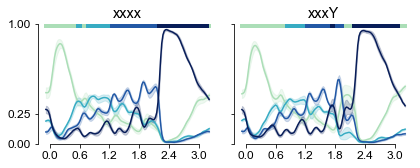

In [49]:
from matplotlib import cm
from skimage.measure import label

item_colors = [# define item colors
    '#D80B29',
       '#ea71e7',
       '#80aeff',
       '#3221AD']
nsess = len(dates)
nitems = Proba.shape[-1]
nbins = len(time_bins_seq)
cmap = cm.get_cmap('YlGnBu')
item_colors = cmap(np.linspace(0.3,1,nitems))
fig,ax = plt.subplots(1,2,figsize=(6,2.5),sharey=True)
titles = ['xxxx','xxxY']
for c in range(2): # xx or xY trials
    all_proba = np.zeros((nitems,nbins))
    for i in range(nitems):
        proba = np.zeros((nsess,Proba.shape[1]))
        for sess in range(nsess):
            ind = (Session==sess) & (Local==c)
            proba[sess,:] = np.mean(Proba[ind,:,i],0)
        av = np.mean(proba,0)
        sem = np.std(proba,0)/np.sqrt(nsess)
        ax[c].plot(time_bins_seq,av,color=item_colors[i])
        ax[c].fill_between(time_bins_seq,av-sem,av+sem,color=item_colors[i],alpha=.2,linewidth=1)
        all_proba[i,:] = av
    
    # plot predicted item number on top
    predicted = np.argmax(all_proba,0)
    for j in range(nitems):
        l = label(predicted==j)
        for clust in range(1,np.max(l)+1):
            ind = l==clust
            ax[c].plot(time_bins_seq[ind],np.ones(sum(ind))*.98,color=item_colors[int(predicted[ind][0])],linewidth=4)
    ax[c].set_xticks(np.arange(0,3.1,soa))
    ax[c].set_title(titles[c])
ax[0].set_ylim(0,1)
ax[0].set_yticks([0,1/nitems,1])
sb.despine(trim=True)
plt.tight_layout()
#plt.savefig(os.path.join(out_path,'plots','PositionCode_%s.pdf'%animal_id))
plt.show()